<a href="https://colab.research.google.com/github/ivoryRabbit/RecSys/blob/master/4.U-AutoRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-AutoRec

- [AutoRec: Autoencoders Meet Collaborative Filtering](http://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf)

## Experiment

In [ ]:
import glob
import numpy as np
import pandas as pd
from typing import Callable, Tuple, List
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Reshape, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import TruncatedNormal, RandomNormal
from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import get_file
import zipfile

In [ ]:
def load_data(data_size : str) -> pd.DataFrame:
    ''' load Movie Lens data '''

    if data_size == '1m':
        fname = 'ml-1m.zip'
        data = 'ml-1m/ratings.dat'
    elif data_size == '10m':
        fname = 'ml-10m.zip'
        data = 'ml-10M100K/ratings.dat'
    elif data_size == '20m':
        fname = 'ml-20m.zip'
        data = 'ml-20m/ratings.csv'
    elif data_size == '25m':
        fname = 'ml-25m.zip'
        data = 'ml-25m/ratings.csv'
    if not glob.glob(data):
        origin = f'http://files.grouplens.org/datasets/movielens/{fname}'
        file = get_file(fname, origin)
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall()

    col_names = ['userId', 'movieId', 'rating', 'timestamp']
    if data_size in ['20m', '25m']:
        ratings = pd.read_csv(data, engine = 'python')
    else:
        ratings = pd.read_csv(data, sep = '|', delimiter = '::', names = col_names, engine = 'python')
    print(ratings.shape)
    return ratings

In [ ]:
ratings = load_data('1m')
ratings.head()

5922816/5917549 [==============================] - 1s 0us/step
(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
n_user = ratings.userId.nunique()
print(f'# of user = {n_user}')

n_item = ratings.movieId.nunique()
print(f'# of item = {n_item}')

# of user = 6040
# of item = 3706


In [ ]:
def train_valid_test_split(df: pd.DataFrame) -> pd.DataFrame:
    train_user, test_user = train_test_split(df.userId.unique(), test_size = 0.2, random_state = 777)
    valid_user, test_user = train_test_split(test_user, test_size = 0.5, random_state = 777)

    train, valid, test = map(lambda x: df[df.userId.isin(x)], (train_user, valid_user, test_user))
    train, valid, test = map(lambda df: df.reset_index(drop = True), (train, valid, test))
    return train, valid, test

def query_answer_split(df: pd.DataFrame) -> pd.DataFrame:
    timeorder = df.groupby(by = 'userId')['timestamp'].rank(method = 'first', ascending = True)
    seen_cnts = df.groupby(by = 'userId', as_index = False).agg(seen_cnts = ('movieId', 'count'))
    df = df.merge(seen_cnts, how = 'left', on = 'userId')
    df = df.assign(timeorder = timeorder)
    df = df.assign(split_type = np.where(df.timeorder < df.seen_cnts * 0.8, 'query', 'answer'))
    query = df[df.split_type == 'query']
    answer = df[df.split_type == 'answer']
    answer = answer[answer.userId.isin(query.userId.unique())]
    query, answer = map(lambda df: df.drop(columns = ['timeorder', 'seen_cnts', 'split_type']), (query, answer))
    query, answer = map(lambda df: df.reset_index(drop = True), (query, answer))
    return query, answer

def cut_off(df: pd.DataFrame, threshold = 4) -> pd.DataFrame:
    return df[df.rating >= threshold].reset_index(drop = True)

def make_warm(df: pd.DataFrame, threshold = 5) -> pd.DataFrame: # remove cold starters
    positive = df.groupby('userId')['movieId'].nunique()
    positive = positive.index[positive >= threshold]
    return df[df.userId.isin(positive)].reset_index(drop = True)

def list_aggregation(df: pd.DataFrame, user_based = True) -> pd.DataFrame:
    if user_based:
        return df.groupby('userId', as_index = False)[['movieId', 'rating']].agg(list)
    else:
        return df.groupby('movieId', as_index = False)[['userId', 'rating']].agg(list)

In [ ]:
idx_user_map = ratings.userId.unique()
user_idx_map = {e: i for i, e in enumerate(idx_user_map)}

idx_item_map = ratings.movieId.unique()
item_idx_map = {e: i for i, e in enumerate(idx_item_map)}

In [ ]:
def Id2idx(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.map(user_idx_map), 
                     movieId = lambda x: x.movieId.map(item_idx_map))

def idx2Id(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(userId = lambda x: x.userId.apply(lambda x: idx_user_map[x]), 
                     movieId = lambda x: x.movieId.apply(lambda x: idx_item_map[x]))

In [ ]:
ratings = Id2idx(ratings)
 
print(ratings.shape)
ratings.head(5)

(1000209, 4)


,userId,movieId,rating,timestamp
0,0,0,5,978300760
1,0,1,3,978302109
2,0,2,3,978301968
3,0,3,4,978300275
4,0,4,5,978824291


In [ ]:
def train_generator(df: pd.DataFrame, 
                    n_user: int,
                    n_item: int, 
                    batch_size: int, 
                    user_based = True) -> Tuple[np.array]:

    n_row = df.index.size
    n_col = n_item if user_based else n_user

    Ids = np.arange(n_row)
    profiles = df['movieId'] if user_based else df['userId']

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        np.random.shuffle(Ids)
        
        for batch_step in range(n_batch):         
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch = np.zeros(shape = (batch_Id.size, n_col))
            for i, idx in enumerate(batch_Id):
                batch[i, profiles[idx]] = 1.0
            
            yield batch, batch

In [ ]:
def valid_generator(query: pd.DataFrame,
                    answer: pd.DataFrame,
                    n_user: int,
                    n_item: int,
                    batch_size: int,
                    user_based = True) -> Tuple[np.array]:

    n_row = query.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile_q = query['movieId']
    profile_a = answer['movieId']

    n_batch = int(np.ceil(n_row / batch_size))
    while True:
        for batch_step in range(n_batch):
            lower = batch_step * batch_size
            upper = lower + batch_size
            
            batch_Id = Ids[lower: upper]
            batch_q = np.zeros(shape = (batch_Id.size, n_col))
            batch_a = np.zeros(shape = (batch_Id.size, n_col))

            for i, idx in enumerate(batch_Id):
                obs = np.array(profile_q[idx]) # seen
                ubs = np.array(profile_a[idx]) # unseen

                batch_q[i, obs] = 1.0
                batch_a[i, ubs] = 1.0
                batch_a[i, obs] = -1.0 # to mark seen-data

            yield batch_q, batch_a

In [ ]:
def masked_cross_entropy(y_true: np.array, y_pred: np.array, masked_value = 0) -> tf.Tensor:
    mask_true = K.cast(K.not_equal(y_true, masked_value), dtype = 'float32')
    masked_ce = mask_true * y_true * K.log(y_pred + K.epsilon())
    return -K.sum(masked_ce, axis = -1) / K.sum(mask_true, axis = -1)

def batch_ndcg(y_true: tf.Tensor, y_pred: tf.Tensor, k = 100) -> tf.Tensor: # only for validation
    rec = tf.where(y_true == -1.0, -1.0, y_pred) # leave only unseen-data
    rec = tf.argsort(rec, axis = -1, direction = 'DESCENDING')[:, :k]

    row = tf.repeat(tf.range(tf.shape(y_true)[0]), k)
    row = tf.expand_dims(row, axis = 1)
    col = tf.reshape(rec, shape = [-1])
    col = tf.expand_dims(col, axis = 1)
    loc = tf.concat([row, col], axis = 1)

    top_k = tf.reshape(tf.gather_nd(y_true, loc), shape = tf.shape(rec))
    ideal = tf.sort(y_true, axis = 1, direction = 'DESCENDING')[:, :k]

    weight = tf.range(2, 102, dtype = 'float32')
    weight = tf.math.log(weight)
    weight = tf.math.reciprocal(weight)
    
    dcg = tf.reduce_sum(top_k * weight, axis = 1)    
    idcg = tf.reduce_sum(tf.where(ideal == -1.0, 0.0, ideal * weight), axis = 1)
    return dcg / idcg

In [ ]:
def AutoRec(n_user: int, 
            n_item: int, 
            user_based = True, 
            latent_dim = 500) -> Callable:

    initializer = RandomNormal(mean = 0.0, stddev = 0.05, seed = None)
    regularizer = l2(0.001)
    
    input_shape = n_item if user_based else n_user

    inputs = Input(shape = (input_shape, ), name = 'input')
    latents = Dense(latent_dim, activation = 'linear', kernel_initializer = initializer, kernel_regularizer = regularizer, name = 'encoder')(inputs)
    outputs = Dense(input_shape, activation = 'sigmoid', kernel_initializer = initializer, kernel_regularizer = regularizer, name = 'decoder')(latents)

    return Model(inputs = inputs, outputs = outputs)

In [ ]:
def test_predictor(df: pd.DataFrame, 
                   model: Callable, 
                   n_item: int, 
                   batch_size: int, 
                   N = 100) -> float:

    n_row = df.index.size
    n_col = n_item

    Ids = np.arange(n_row)
    profile = df['movieId']

    pred = []
    steps = int(np.ceil(n_row / batch_size))
    for batch_step in range(steps):
        lower = batch_step * batch_size
        upper = lower + batch_size

        batch_Id = Ids[lower: upper]
        y_true = np.zeros(shape = (batch_Id.size, n_col))
        for i, idx in enumerate(batch_Id):
            y_true[i, profile[idx]] = 1.0

        y_pred = model.predict(y_true, verbose = 0)
        
        cand = np.argsort(np.where(y_true == 1.0, -1.0, y_pred), axis = -1)[:, :-N-1:-1]
        pred.append(cand)
    pred = np.concatenate(pred)
    pred = [{'userId': df.at[i, 'userId'], 'movieId': pred[i]} for i in range(n_row)]
    return pd.DataFrame(pred)

In [ ]:
def show_history(history, loss: str, metric: str) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

    ax1.plot(history[f'{loss}'])
    ax1.plot(history[f'val_{loss}'])
    ax1.set_title(loss, fontsize = 20)
    ax1.set_ylabel(loss)
    ax1.set_xlabel('epoch')
    ax1.legend([loss, f'val_{loss}'], loc = 'upper right')

    ax2.plot(history[f'{metric}'])
    ax2.plot(history[f'val_{metric}'])
    ax2.set_title(metric, fontsize = 20)
    ax2.set_ylabel(metric)
    ax2.set_xlabel('epoch')
    ax2.legend([metric, f'val_{metric}'], loc = 'upper right')
    plt.show()

In [ ]:
class evaluate:
    def __init__(self, true: pd.DataFrame, pred: pd.DataFrame):
        self.true = true
        self.pred = pred
        self.max_K = 10000
        self.idcg = np.cumsum([1.0 / np.log(i+2) for i in range(self.max_K)])

    def _recall(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / np.min([K, len(gt)])
    
    def _precision(self, gt: List, rec: List, K = None) -> float:
        K = K if K else self.max_K
        res = [r for r in rec[:K] if r in gt]
        return len(res) / len(rec[:K])

    def _AP(self, gt: List, rec: List, K = None) -> float: # Average Precision
        K = K if K else self.max_K
        res = 0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                res += self._precision(gt, rec[:K], i+1)
        return res / np.min([K, len(gt)])

    def _RR(self, gt: List, rec: List, K = None) -> float: # Reciprocal Rank
        K = K if K else self.max_K
        for i, r in enumerate(rec[:K]):
            if r in gt:
                return  1.0 / (i+1)
        return 0

    def _nDCG(self, gt: List, rec: List, K = None) -> float: # normalized Discounted Cumulative Gain
        K = K if K else self.max_K
        dcg = 0.0
        for i, r in enumerate(rec[:K]):
            if r in gt:
                dcg += 1.0 / np.log(i+2)
        idcg = self.idcg[min([len(gt), K])-1]
        return dcg / idcg
    
    def __call__(self, K = None):
        self.K = K
        self.recall = 0
        self.precision = 0
        self.MAP = 0
        self.MRR = 0
        self.nDCG = 0
        n = self.true.index.size
        for gt, rec in zip(tqdm(self.true.movieId), self.pred.movieId):
            self.recall += self._recall(gt, rec, K) / n
            self.precision += self._precision(gt, rec, K) / n
            self.MAP += self._AP(gt, rec, K) / n
            self.MRR += self._RR(gt, rec, K) / n
            self.nDCG += self._nDCG(gt, rec, K) / n

    def print_all(self):
        K = '@' + str(self.K) if self.K else ''
        print(f'{"Recall":>12}{K} : {self.recall:.5f}',
              f'\n{"Precision":>12}{K} : {self.precision:.5f}',
              f'\n{"MAP":>12}{K} : {self.MAP:.5f}',
              f'\n{"nRR":>12}{K} : {self.MRR:.5f}',
              f'\n{"nDCG":>12}{K} : {self.nDCG:.5f}')

## 1. U-AutoRec

In [ ]:
ratings = cut_off(ratings)

train, valid, test = train_valid_test_split(ratings)
train = list_aggregation(train)

(valid_q, valid_a), (test_q, test_a) = map(query_answer_split, (valid, test))
valid_q, valid_a, test_q, test_a = map(list_aggregation, (valid_q, valid_a, test_q, test_a))

In [ ]:
epochs = 200
batch_size = 128

train_gen = train_generator(train, n_user, n_item, batch_size)
valid_gen = valid_generator(valid_q, valid_a, n_user, n_item, batch_size)

steps_per_epoch = train.index.size // batch_size + 1
validation_steps = valid.index.size // batch_size + 1

In [ ]:
model = AutoRec(n_user, n_item, user_based = True, latent_dim = 500)
model.compile(optimizer = 'adamax', loss = masked_cross_entropy, metrics = batch_ndcg)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3706)]            0         
_________________________________________________________________
encoder (Dense)              (None, 500)               1853500   
_________________________________________________________________
decoder (Dense)              (None, 3706)              1856706   
Total params: 3,710,206
Trainable params: 3,710,206
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
early_stopping = EarlyStopping(monitor = 'val_batch_ndcg', mode = 'max', verbose = 1, patience = epochs // 10)
model_checkpoint = ModelCheckpoint('U-AutoRec.h5', monitor = 'val_batch_ndcg', mode = 'max', save_best_only = True)

hist = model.fit(x = train_gen, validation_data = valid_gen, epochs = epochs,
                 steps_per_epoch = steps_per_epoch, validation_steps = validation_steps, 
                 verbose = 1, callbacks = [early_stopping, model_checkpoint])

Epoch 1/200
38/38 [==============================] - 5s 131ms/step - loss: 6.4456 - batch_ndcg: 0.2910 - val_loss: 3.6361 - val_batch_ndcg: 0.1431
Epoch 2/200
38/38 [==============================] - 4s 118ms/step - loss: 2.7338 - batch_ndcg: 0.3804 - val_loss: 1.6230 - val_batch_ndcg: 0.1433
Epoch 3/200
38/38 [==============================] - 4s 117ms/step - loss: 1.3425 - batch_ndcg: 0.3629 - val_loss: 0.7853 - val_batch_ndcg: 0.1396
Epoch 4/200
38/38 [==============================] - 4s 114ms/step - loss: 0.7424 - batch_ndcg: 0.3551 - val_loss: 0.4106 - val_batch_ndcg: 0.1386
Epoch 5/200
38/38 [==============================] - 4s 115ms/step - loss: 0.4617 - batch_ndcg: 0.3515 - val_loss: 0.2326 - val_batch_ndcg: 0.1379
Epoch 6/200
38/38 [==============================] - 4s 111ms/step - loss: 0.3225 - batch_ndcg: 0.3487 - val_loss: 0.1452 - val_batch_ndcg: 0.1361
Epoch 7/200
38/38 [==============================] - 4s 114ms/step - loss: 0.2500 - batch_ndcg: 0.3460 - val_loss: 0.1

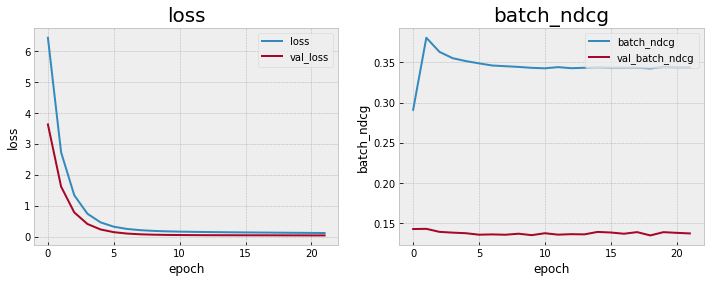

In [ ]:
show_history(hist.history, 'loss', 'batch_ndcg')

In [ ]:
pred = test_predictor(test_q, model, n_item, batch_size, N = 100)
pred.head(5)

,userId,movieId
0,4,"[44, 48, 64, 38, 92, 68, 23, 669, 97, 127, 113..."
1,9,"[104, 44, 48, 128, 23, 68, 669, 0, 124, 246, 5..."
2,14,"[44, 64, 184, 128, 669, 97, 124, 246, 5, 22, 5..."
3,44,"[104, 44, 48, 38, 64, 184, 128, 92, 68, 23, 66..."
4,59,"[104, 44, 48, 38, 64, 184, 128, 68, 92, 23, 66..."


In [ ]:
eval = evaluate(test_a, pred)

eval(K = 20)
eval.print_all()

eval(K = 100)
eval.print_all()


      Recall@20 : 0.10628 
   Precision@20 : 0.06258 
         MAP@20 : 0.03165 
         nRR@20 : 0.19946 
        nDCG@20 : 0.09204



      Recall@100 : 0.25875 
   Precision@100 : 0.04031 
         MAP@100 : 0.03938 
         nRR@100 : 0.20686 
        nDCG@100 : 0.15268
